## 1. Setup and Imports

In [1]:
from pathlib import Path
import sys
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import importlib

# Find repository root
def find_repo_root(max_up=6):
    p = Path.cwd().resolve()
    for _ in range(max_up):
        if (p / 'README.md').exists() or (p / '.git').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd().resolve()

repo_root = find_repo_root()

# Add paths
for path in ['src/', 'scripts/']:
    full_path = str(repo_root / path)
    if full_path not in sys.path:
        sys.path.insert(1, full_path)

import network_clust as netclust

# Output paths
FIG_PATH = repo_root / 'results' / 'figures'
NETWORK_PATH = repo_root / 'data' / 'networks'

print(f"Repository root: {repo_root}")
print(f"Figures: {FIG_PATH}")

Repository root: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model
Figures: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/figures


## 2. Load Network

In [2]:
# Configuration
JOIN = True   # Use joined network (connects floating buses)
FLOAT_ = True  # Include floating buses

# Load network - use SC+ (Simplified + Connected) version from network_03
network_file = f"SC+_sEEN{'_join' if JOIN else ''}{'_f' if FLOAT_ else ''}.nc"
n = pypsa.Network(NETWORK_PATH / 'base' / network_file)

print(f"Loaded: {network_file}")
print(f"  Buses: {len(n.buses)}")
print(f"  Lines: {len(n.lines)}")
print(f"  Links: {len(n.links)}")
print(f"  Countries: {len(n.buses.country.unique())}")

INFO:pypsa.network.io:Imported network 'Simplified European Electricity Network [join] [float] [simple]' has buses, carriers, lines, loads, sub_networks


Loaded: SC+_sEEN_join_f.nc
  Buses: 3954
  Lines: 5579
  Links: 0
  Countries: 28


## 3. Calculate Cluster Weights

We use total load per bus as the clustering weight. This ensures high-load buses are well-represented in the clustered network.

In [3]:
# Calculate load weights
load_per_bus = n.loads_t.p_set.sum(axis=0)
bus_loads = load_per_bus.groupby(n.loads.bus).sum()
bus_weights = pd.Series(0.0, index=n.buses.index)
bus_weights.loc[bus_loads.index] = bus_loads

# Country statistics
country_stats = pd.DataFrame({
    'buses': n.buses.groupby('country').size(),
    'load_TWh': bus_weights.groupby(n.buses.country).sum() / 1e6,
    'load_pct': (bus_weights.groupby(n.buses.country).sum() / bus_weights.sum() * 100).round(2),
}).sort_values('load_TWh', ascending=False)

print("Top 15 Countries by Load:")
print(country_stats.head(15))
print(f"\nTotal: {len(n.buses)} buses, {bus_weights.sum()/1e6:.2f} TWh")

Top 15 Countries by Load:
         buses     load_TWh  load_pct
country                              
DE         479  2161.531044     17.98
FR         785  1770.646688     14.73
IT         417  1581.725234     13.16
ES         561  1209.768985     10.06
PL         147   976.116074      8.12
RO          91   510.082350      4.24
NL          38   435.799127      3.62
BE          41   296.187696      2.46
GR          26   280.505793      2.33
SE         132   275.064118      2.29
CZ          40   274.739971      2.29
HU          38   262.842586      2.19
AT          60   258.088610      2.15
PT          88   256.368640      2.13
CH         126   245.099008      2.04

Total: 3954 buses, 12022.23 TWh


## 4. Configure Clustering

### Parameters:
- **n_clusters_target**: Total number of clusters (200-500 typical)
- **focus_weights**: Override proportional allocation for specific countries
- **min_clusters_per_country**: Minimum clusters for main sub-network (prevents line loss)

### Focus Weights
Focus weights ensure peripheral countries get adequate representation:
- Specified countries get their stated fraction of total clusters
- Remaining countries share (1 - sum(focus_weights)) proportionally by load
- **PyPSA-EUR method**: Weights are divided across sub-networks per country

In [4]:
# Clustering configuration
n_clusters_target = 125  
# INCREASED: More clusters for better line retention
# Focus weights for underrepresented countries
# These get their specified fraction of total clusters
focus_weights = {'PL': 0.1 ,  # Poland - important transit country
                 'ES': 0.1,  # Spain - Iberian peninsula
                 'RO': 0.06,  # Romania - SE Europe
                 'SE': 0.05,  # Sweden - Nordic region
                 'PT': 0.01,  # Portugal
                 'FR': 0.18,
                 'GR': 0.03,  # Greece
                 'GB': 0.1,  # UK - many sub-networks, needs boost
                 'NO': 0.04,  # Norway
                }
# Minimum clusters per country's main sub-network
# INCREASED: This ensures main grids get enough clusters
min_clusters_per_country = 5
print(f"Configuration:")
print(f"Target clusters: {n_clusters_target}")
print(f"Focus countries: {list(focus_weights.keys())}")
print(f"Total focus weight: {sum(focus_weights.values()):.0%}")
print(f"Min clusters/country: {min_clusters_per_country}")


Configuration:
Target clusters: 125
Focus countries: ['PL', 'ES', 'RO', 'SE', 'PT', 'FR', 'GR', 'GB', 'NO']
Total focus weight: 67%
Min clusters/country: 5


## 5. Run Clustering

In [5]:
n.determine_network_topology()

PyPSA Network 'Simplified European Electricity Network [join] [float] [simple]'
-------------------------------------------------------------------------------
Components:
 - Bus: 3954
 - Carrier: 15
 - Line: 5579
 - Load: 6258
 - SubNetwork: 1
Snapshots: 35064

In [6]:
# Reload module to get latest changes
importlib.reload(netclust)

# Determine network topology (required for sub-network identification)
n.determine_network_topology()

# Step 1: Distribute clusters across countries using Gurobi optimization
print("="*70)
print("Step 1: Distributing clusters to countries (Gurobi optimization)")
print("="*70)

n_clusters_c = netclust.distribute_n_clusters_to_countries(
    n,
    n_clusters_target,
    bus_weights,
    focus_weights=focus_weights,
    solver_name='gurobi',
    min_clusters_per_country=min_clusters_per_country
)

# Display allocation summary
country_totals = n_clusters_c.groupby(level='country').sum().sort_values(ascending=False)
print(f"\nCluster allocation by country (top 15):")
print(country_totals.head(15))

INFO:network_clust:Distributing 125 clusters across countries using gurobi
INFO:network_clust:Applying focus weights for 9 countries
INFO:network_clust:Using custom focus weights for determining number of clusters.
INFO:network_clust:Ensuring minimum 5 clusters for main sub-networks
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
 - TimeLimit: 60
 - MIPGap: 0.01
INFO:linopy.io: Writing time: 0.01s


Step 1: Distributing clusters to countries (Gurobi optimization)
Set parameter Username
Set parameter LicenseID to value 2755728
Academic license - for non-commercial use only - expires 2026-12-16
Read LP format model from file /private/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/linopy-problem-u1oc4aqp.lp
Reading time = 0.00 seconds
obj: 1 rows, 28 columns, 28 nonzeros
Set parameter LogToConsole to value 0


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 0 duals
Objective: -7.40e+02
Solver model: available
Solver message: 2

INFO:network_clust:Optimization successful. Clusters per country (top 10):
country
FR    15
DE     9
IT     8
PL     8
ES     8
GB     8
RO     5
SE     4
AT     3
SI     3
Name: n, dtype: int64
INFO:network_clust:UK cluster allocation:
country  sub_network
GB       0              8
Name: n, dtype: int64



Cluster allocation by country (top 15):
country
FR    15
DE     9
IT     8
PL     8
ES     8
GB     8
RO     5
SE     4
AT     3
SI     3
PT     3
NO     3
NL     3
LV     3
LU     3
Name: n, dtype: int64


In [7]:
# Step 2: Create busmap using K-means clustering
print("="*70)
print("Step 2: Creating busmap (K-means clustering)")
print("="*70)

busmap = netclust.busmap_for_n_clusters(
    n,
    n_clusters_c,
    bus_weights,
    algorithm="kmeans"
)

print(f"\nBusmap created:")
print(f"  Original buses: {len(n.buses)}")
print(f"  Unique clusters: {busmap.nunique()}")

INFO:network_clust:Creating busmap using kmeans algorithm


Step 2: Creating busmap (K-means clustering)


INFO:network_clust:Created busmap with 125 unique clusters (including 0 DC)



Busmap created:
  Original buses: 3954
  Unique clusters: 125


In [8]:
# Step 3: Apply clustering to create aggregated network
print("="*70)
print("Step 3: Applying clustering")
print("="*70)

clustering = netclust.clustering_for_n_clusters(n, busmap)
n_clustered = clustering.n

print(f"\nClustering complete:")
print(f"  Buses: {len(n.buses)} → {len(n_clustered.buses)} ({100*(1-len(n_clustered.buses)/len(n.buses)):.1f}% reduction)")
print(f"  Lines: {len(n.lines)} → {len(n_clustered.lines)} ({100*(1-len(n_clustered.lines)/len(n.lines)):.1f}% reduction)")
print(f"  Links: {len(n.links)} → {len(n_clustered.links)}")
print(f"  Computational speedup: ~{(len(n.buses)/len(n_clustered.buses))**2:.0f}x")

INFO:network_clust:Performing network clustering
INFO:network_clust:Removed non-standard line attributes: ['i_nom', 'v_nom']


Step 3: Applying clustering


INFO:network_clust:Clustering complete:
  Buses: 3954 -> 125
  Lines: 5579 -> 236
  Links: 0 -> 0
INFO:network_clust:============================================================
INFO:network_clust:POST-CLUSTERING CONNECTIVITY FIXES
INFO:network_clust:============================================================
INFO:network_clust:Isolated bus analysis:
INFO:network_clust:  Total isolated (no lines): 0
INFO:network_clust:  Already isolated (no links): 0
INFO:network_clust:  Newly isolated (has links): 0
INFO:network_clust:============================================================
INFO:network_clust:CONNECTIVITY FIXES COMPLETE
INFO:network_clust:  Links made bidirectional: 0
INFO:network_clust:  Isolated buses removed: 0
INFO:network_clust:  Buses reconnected: 0
INFO:network_clust:============================================================



Clustering complete:
  Buses: 3954 → 125 (96.8% reduction)
  Lines: 5579 → 236 (95.8% reduction)
  Links: 0 → 0
  Computational speedup: ~1001x


## 6. Analyze Internal Line Retention

Internal lines (within a country) should be preserved during clustering. Low retention indicates clustering is collapsing too many buses.

In [9]:
def count_internal_lines(network):
    """Count internal lines per country."""
    bus_country = network.buses['country']
    results = []
    for country in sorted(bus_country.unique()):
        country_buses = bus_country[bus_country == country].index
        internal = network.lines[
            network.lines['bus0'].isin(country_buses) &
            network.lines['bus1'].isin(country_buses)
        ]
        results.append({'country': country, 'buses': len(country_buses), 'internal_lines': len(internal)})
    return pd.DataFrame(results).set_index('country')

# Compare before/after
original = count_internal_lines(n)
clustered = count_internal_lines(n_clustered)

comparison = pd.DataFrame({
    'buses_before': original['buses'],
    'buses_after': clustered['buses'],
    'lines_before': original['internal_lines'],
    'lines_after': clustered['internal_lines'],
})
comparison['retention_%'] = (comparison['lines_after'] / comparison['lines_before'] * 100).fillna(0).round(1)

# Show countries with significant networks (>50 original lines)
significant = comparison[comparison['lines_before'] >= 50].sort_values('lines_before', ascending=False)

print("Internal Line Retention (countries with 50+ original lines):")
print(significant)

# Highlight any problem countries
problems = significant[significant['retention_%'] < 10]
if len(problems) > 0:
    print(f"\n⚠️  WARNING: {len(problems)} countries with <10% retention:")
    print(problems[['lines_before', 'lines_after', 'retention_%']])

Internal Line Retention (countries with 50+ original lines):
         buses_before  buses_after  lines_before  lines_after  retention_%
country                                                                   
FR                785           15          1179           27          2.3
ES                561            8           788           12          1.5
DE                479            9           658           13          2.0
IT                417            8           563            8          1.4
GB                314            8           420            9          2.1
NO                217            3           253            2          0.8
PL                147            8           225           12          5.3
SE                132            4           179            4          2.2
CH                126            3           165            2          1.2
PT                 88            3           141            2          1.4
RO                 91            5     

In [10]:
# Analyze UK specifically
uk_buses_orig = n.buses[n.buses['country'] == 'GB']
uk_buses_clust = n_clustered.buses[n_clustered.buses['country'] == 'GB']
print("UK Sub-Network Analysis:")
print("="*60)
print(f"\nOriginal UK buses per sub-network:")
print(uk_buses_orig.groupby('sub_network').size().sort_values(ascending=False))
print(f"\nClustered UK buses per sub-network:")
print(uk_buses_clust.groupby('sub_network').size().sort_values(ascending=False))
print(f"\nUK internal lines:")
uk_buses_clust_idx = uk_buses_clust.index
uk_internal_lines = n_clustered.lines[n_clustered.lines['bus0'].isin(uk_buses_clust_idx) & n_clustered.lines['bus1'].isin(uk_buses_clust_idx)]
print(f"Total: {len(uk_internal_lines)}")
print(f"\nLine details:")
for idx, row in uk_internal_lines.iterrows():
    print(f"{row['bus0']} <-> {row['bus1']} (s_nom={row['s_nom']:.0f} MW)")

UK Sub-Network Analysis:

Original UK buses per sub-network:
sub_network
0    314
dtype: int64

Clustered UK buses per sub-network:
sub_network
0    8
dtype: int64

UK internal lines:
Total: 9

Line details:
GB0 0 <-> GB0 2 (s_nom=7150 MW)
GB0 0 <-> GB0 3 (s_nom=7150 MW)
GB0 0 <-> GB0 4 (s_nom=5418 MW)
GB0 0 <-> GB0 5 (s_nom=11702 MW)
GB0 2 <-> GB0 3 (s_nom=17875 MW)
GB0 3 <-> GB0 5 (s_nom=10725 MW)
GB0 3 <-> GB0 6 (s_nom=16143 MW)
GB0 4 <-> GB0 5 (s_nom=5575 MW)
GB0 4 <-> GB0 7 (s_nom=12792 MW)


In [11]:
voronoi_path = repo_root / 'data' / 'cache' / 'geometry' / "voronoi_eu27_join_P.parquet"
voronoi = gpd.read_parquet(voronoi_path)
busmap

name
AT1-220              AT0 2
AT10-220             AT0 0
AT11-220             AT0 1
AT12-380             AT0 2
AT13-380             AT0 2
                     ...  
way/648002755-400    SK0 2
way/666404730-400    SK0 1
way/672771472-400    SK0 0
way/783483874-400    SK0 1
way/93468022-400     SK0 2
Name: busmap, Length: 3954, dtype: object

In [12]:
voronoi

,geometry,bus_id,bus_x,bus_y,region,country,area_km2,bounded,population,EU_population_share
0,"POLYGON ((16.47213 48.68105, 16.44706 48.7116,...",AT1-220,16.807409,48.709909,combined,AT,1385.430479,True,139398.0,0.000308
1,"POLYGON ((12.9523 47.51901, 13.15077 47.59155,...",AT10-220,13.212633,47.330377,combined,AT,998.596542,True,43914.0,0.000097
2,"POLYGON ((10.98191 47.57542, 11.26117 47.3334,...",AT11-220,11.102718,47.293961,combined,AT,531.999239,True,56400.0,0.000125
3,"POLYGON ((16.26957 47.52466, 16.14328 46.83168...",AT12-380,16.166650,47.270734,combined,AT,654.566186,True,58819.0,0.000130
4,"POLYGON ((16.06185 47.47621, 16.10692 46.89546...",AT13-380,15.990006,47.257024,combined,AT,1188.430975,True,84807.0,0.000188
...,...,...,...,...,...,...,...,...,...,...
6253,"POLYGON ((8.04853 44.67145, 8.11555 44.4672, 8...",way/99694910-380,7.789278,44.462732,combined,IT,2019.032168,True,193905.0,0.000429
6254,"POLYGON ((-0.42327 47.02423, -0.4795 47.09112,...",way/99722046-225,-0.114171,47.206984,combined,FR,873.174164,True,38190.0,0.000084
6255,"POLYGON ((-0.00242 47.57991, 0.01193 47.40883,...",way/99722046-400,-0.113930,47.207199,combined,FR,750.559992,True,72170.0,0.000160
6256,"POLYGON ((7.94057 44.67052, 7.82795 44.66947, ...",way/99826025-220,7.785444,44.875461,combined,IT,128.953109,True,39130.0,0.000087


## 7. Visualize Results

Saved: network_clustering_join_float_gurobi_125_adj2.png


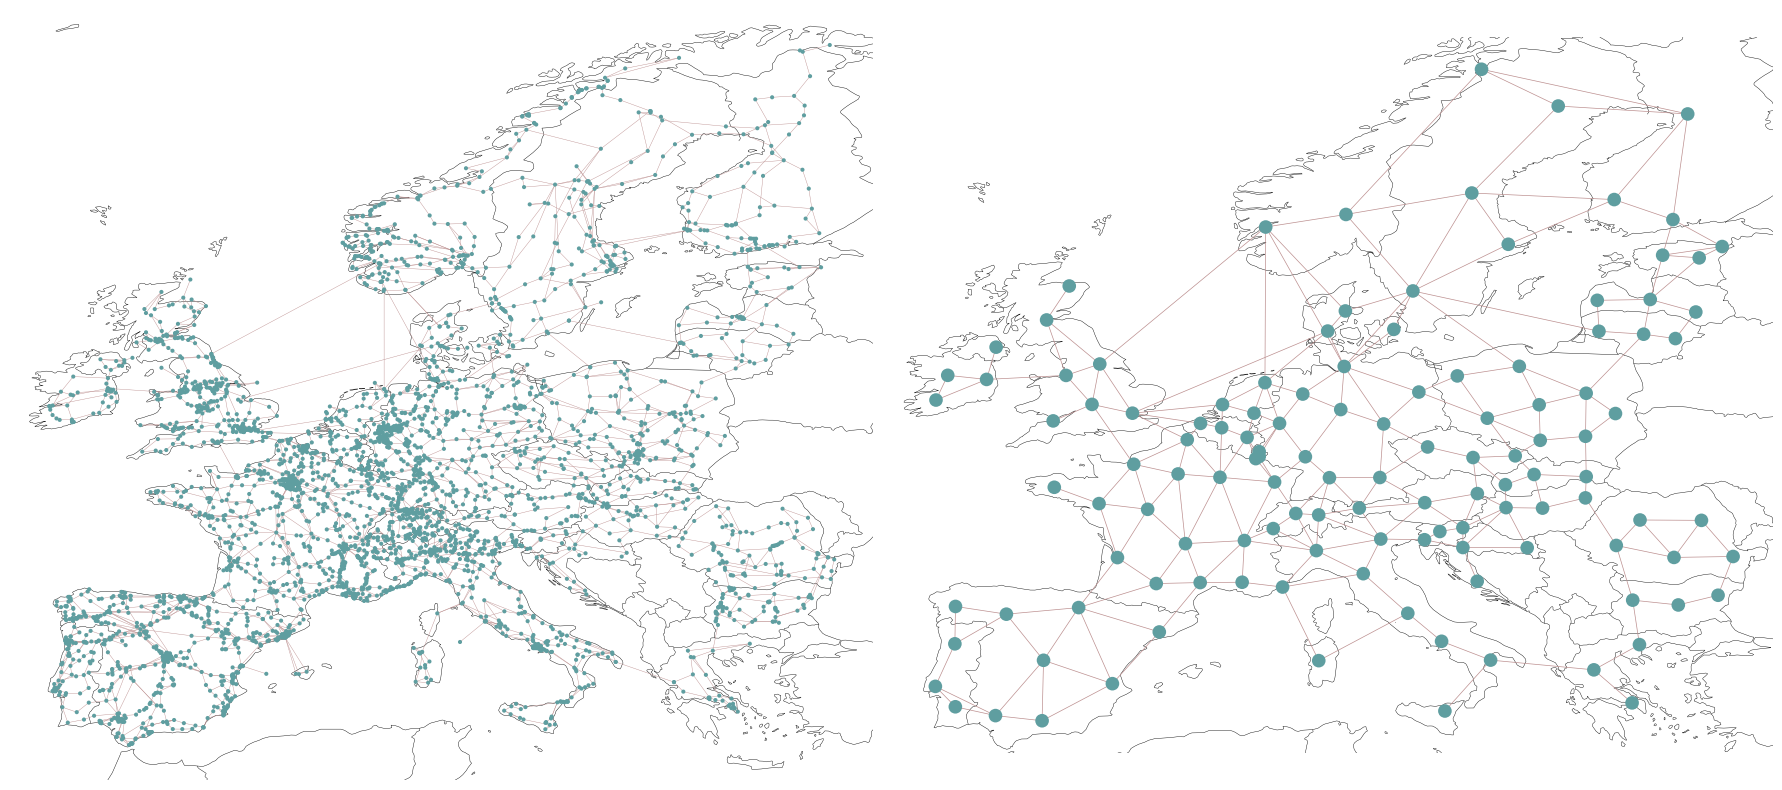

In [ ]:
# Create comparison plot
fig = plt.figure(figsize=(18, 8))
proj = ccrs.PlateCarree()

# Original network
ax1 = fig.add_subplot(1, 2, 1, projection=proj)
ax1.set_title(f'Simplified Network ({len(n.buses)} buses)', fontsize=14, fontweight='bold')
n.plot(ax=ax1, bus_sizes=0.01, line_widths=0.3, link_widths=0.5, margin=0.05)

# Clustered network
ax2 = fig.add_subplot(1, 2, 2, projection=proj)
ax2.set_title(f'Clustered Network ({len(n_clustered.buses)} buses)', fontsize=14, fontweight='bold')
n_clustered.plot(ax=ax2, bus_sizes=0.1, line_widths=0.5, link_widths=1.0, margin=0.05)

plt.tight_layout()

# Save figure
fig_name = f'network_clustering_{"join" if JOIN else "nojoin"}_{"float" if FLOAT_ else "nofloat"}_gurobi_{n_clusters_target}.png'
plt.savefig(FIG_PATH / fig_name, dpi=300, bbox_inches='tight')
print(f"Saved: {fig_name}")

plt.show()

## 7.1 Visualize Clustered Voronoi Cells

Apply the busmap to aggregate voronoi geometries by cluster and visualize alongside the network.

Creating clustered voronoi cells...
Mapped voronoi -> cluster (after tries): 3949 / 6258
Assigning nearest medoid to 2309 unmapped voronoi cells


/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_90721/2924283129.py:66: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




Clustered voronoi cells (after fill): 125

Saved: network_clustering_voronoi_join_float_gurobi_125_adj2.png


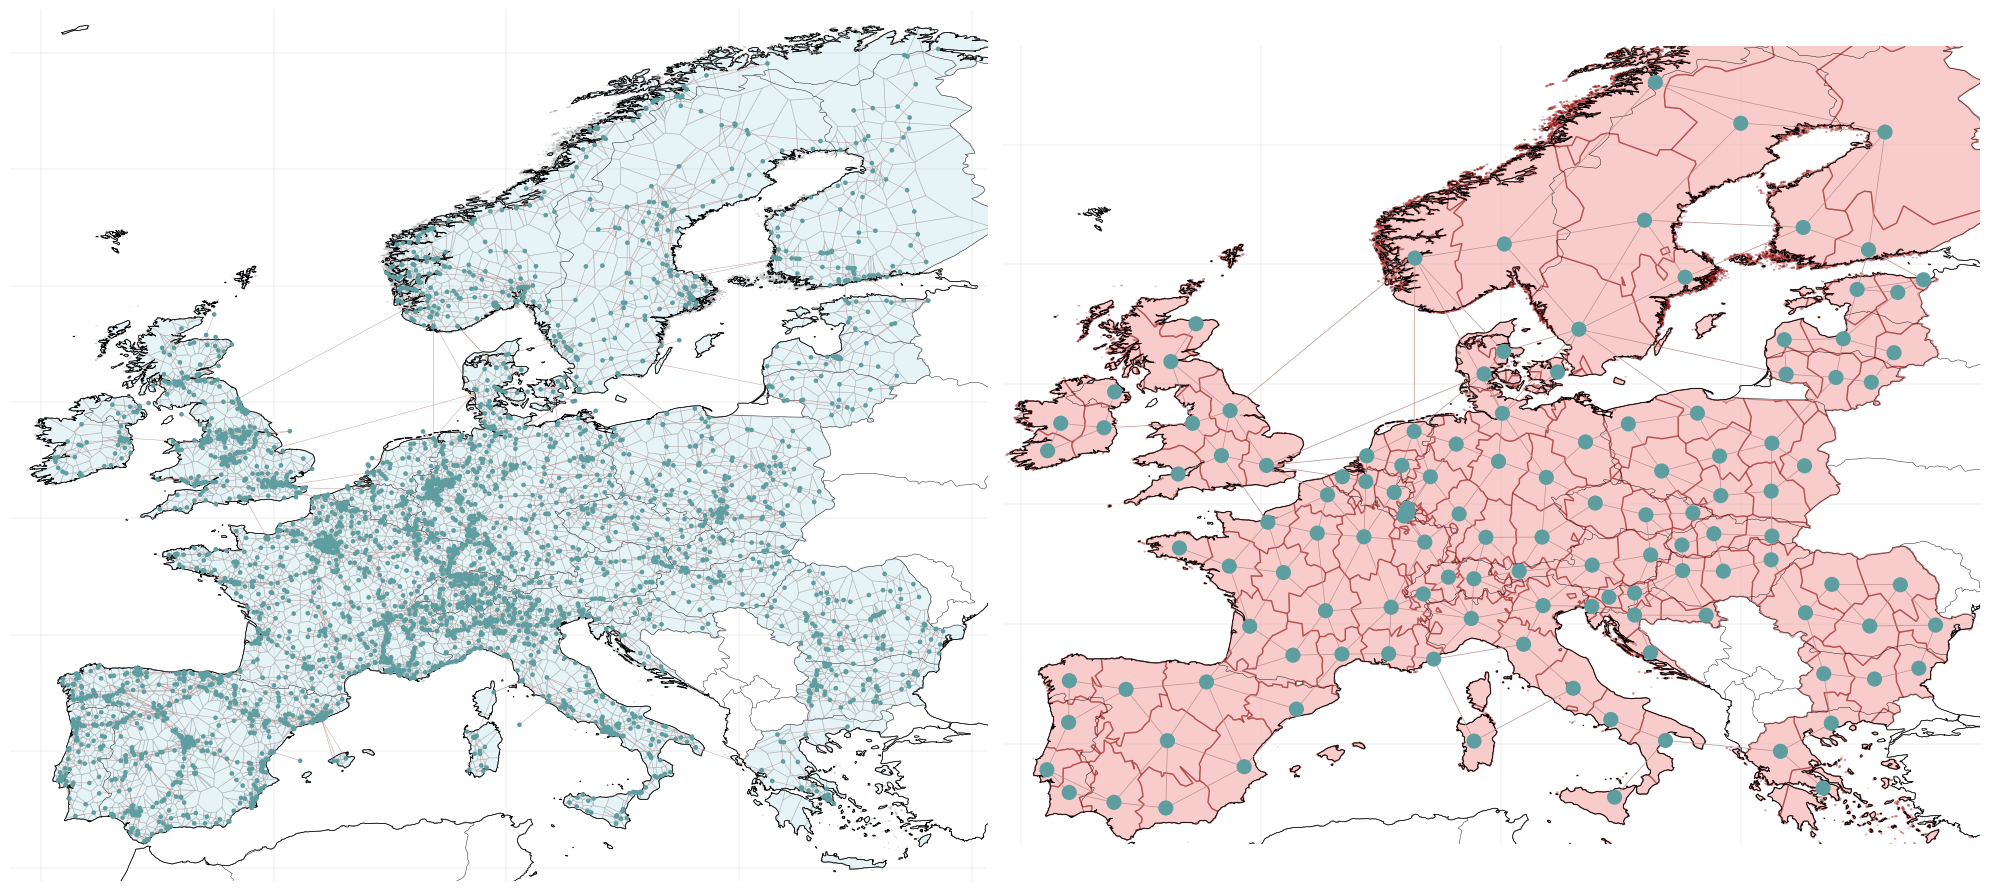

In [ ]:
# Apply busmap to voronoi to create clustered voronoi cells
# Each cluster gets the union of all voronoi geometries that map to it

print("Creating clustered voronoi cells...")

# Defensive copy
voronoi_df = voronoi.copy()

# Prepare busmap as a Series for fast lookup
if isinstance(busmap, pd.Series):
    busmap_s = busmap
else:
    try:
        busmap_s = pd.Series(busmap)
    except Exception:
        busmap_s = pd.Series(dict(busmap))

# Try mapping using index first (most common)
mapped = voronoi_df.index.map(lambda k: busmap_s.get(k) if k in busmap_s.index else None)
voronoi_df = voronoi_df.assign(cluster=mapped)

# If many unmapped, try mapping using common column names
unmapped_mask = voronoi_df['cluster'].isna()
if unmapped_mask.any():
    for col in ['bus', 'bus_id', 'id', 'index', 'gid', 'node', 'orig_index']:
        if col in voronoi_df.columns:
            mapped2 = voronoi_df.loc[unmapped_mask, col].map(busmap_s)
            voronoi_df.loc[unmapped_mask, 'cluster'] = mapped2
            unmapped_mask = voronoi_df['cluster'].isna()
            if not unmapped_mask.any():
                break

# As a last attempt, try string-key mapping (sometimes types differ)
unmapped_mask = voronoi_df['cluster'].isna()
if unmapped_mask.any():
    busmap_str = pd.Series({str(k): v for k, v in busmap_s.items()})
    mapped3 = voronoi_df.loc[unmapped_mask].index.map(lambda k: busmap_str.get(str(k)))
    voronoi_df.loc[unmapped_mask, 'cluster'] = mapped3
    unmapped_mask = voronoi_df['cluster'].isna()

print(f"Mapped voronoi -> cluster (after tries): {voronoi_df['cluster'].notna().sum()} / {len(voronoi_df)}")

# Ensure CRS is set and in EPSG:4326
if voronoi_df.crs and voronoi_df.crs.to_string() != 'EPSG:4326':
    voronoi_df = voronoi_df.to_crs('EPSG:4326')

# If there are still unmapped rows, assign nearest medoid by centroid distance
unmapped_idx = voronoi_df[voronoi_df['cluster'].isna()].index
if len(unmapped_idx) > 0:
    print(f"Assigning nearest medoid to {len(unmapped_idx)} unmapped voronoi cells")
    # Prepare medoid coordinates from clustered network
    if {'x', 'y'}.issubset(n_clustered.buses.columns):
        medoids_df = n_clustered.buses[['x', 'y']].dropna()
    elif {'x', 'y'}.issubset(n.buses.columns):
        medoids_df = n.buses[['x', 'y']].dropna()
    else:
        medoids_df = pd.DataFrame(columns=['x', 'y'])

    if len(medoids_df) == 0:
        print('No medoid coordinates available to assign nearest; will fill with fallbacks later')
    else:
        medoid_idx = medoids_df.index.to_numpy()
        medoid_coords = medoids_df[['x', 'y']].to_numpy()

        # Compute centroids for unmapped voronoi rows
        centroids = voronoi_df.loc[unmapped_idx].geometry.centroid
        centroid_coords = np.vstack([ (c.x, c.y) for c in centroids ])

        # Compute squared distances (vectorised)
        d2 = ((centroid_coords[:, None, :] - medoid_coords[None, :, :]) ** 2).sum(axis=2)
        nearest = d2.argmin(axis=1)
        assigned = medoid_idx[nearest]

        voronoi_df.loc[unmapped_idx, 'cluster'] = assigned

# Now dissolve by cluster to create aggregated polygons
voronoi_clustered = voronoi_df.dropna(subset=['cluster']).copy()
voronoi_clustered['cluster'] = voronoi_clustered['cluster'].astype(object)
voronoi_aggregated = voronoi_clustered.dissolve(by='cluster', as_index=True)

# Fix invalid geometries
if not voronoi_aggregated.empty:
    try:
        voronoi_aggregated['geometry'] = voronoi_aggregated.geometry.buffer(0)
    except Exception:
        pass

# Reindex against medoids to ensure every medoid appears
try:
    medoids = pd.Index(n_clustered.buses.index)
except Exception:
    medoids = pd.Index(np.unique(list(busmap_s.values())))

voronoi_clusters_full = voronoi_aggregated.reindex(medoids)

# For medoids still missing polygons, create buffered fallback from medoid coords
missing = voronoi_clusters_full[voronoi_clusters_full.geometry.isna()].index.tolist()
if missing:
    print(f"Medoids still missing polygons: {len(missing)} — creating fallback buffered points")
    from shapely.geometry import Point
    fallback_geoms = {}
    buffer_deg = 0.05
    for med in missing:
        geom = None
        if med in n_clustered.buses.index and {'x','y'}.issubset(n_clustered.buses.columns):
            x = n_clustered.buses.loc[med, 'x']
            y = n_clustered.buses.loc[med, 'y']
            if not pd.isna(x) and not pd.isna(y):
                geom = Point(x, y).buffer(buffer_deg)
        if geom is None and med in n.buses.index and {'x','y'}.issubset(n.buses.columns):
            x = n.buses.loc[med, 'x']
            y = n.buses.loc[med, 'y']
            if not pd.isna(x) and not pd.isna(y):
                geom = Point(x, y).buffer(buffer_deg)
        voronoi_clusters_full.at[med, 'geometry'] = geom

# Ensure GeoDataFrame and CRS
if not isinstance(voronoi_clusters_full, gpd.GeoDataFrame):
    voronoi_clusters_full = gpd.GeoDataFrame(voronoi_clusters_full)
if voronoi_clusters_full.crs is None:
    voronoi_clusters_full.set_crs('EPSG:4326', inplace=True)

print(f"Clustered voronoi cells (after fill): {len(voronoi_clusters_full)}")

# Plotting
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_title(f'Original Network ({len(n.buses)} buses) with Voronoi Cells', fontsize=14, fontweight='bold')

if not voronoi_df.empty:
    try:
        voronoi_df.plot(ax=ax1, facecolor='lightblue', edgecolor='gray', alpha=0.3, linewidth=0.5, transform=ccrs.PlateCarree(), zorder=1)
    except Exception as e:
        print('Warning plotting original voronoi:', e)

ax1.coastlines(resolution='10m', linewidth=0.5, zorder=2)
ax1.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5, zorder=2)

n.plot(ax=ax1, bus_sizes=0.01, line_widths=0.3, link_widths=0.5, margin=0.05)

ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_title(f'Clustered Network ({len(n_clustered.buses)} buses) with Clustered Voronoi Cells', fontsize=14, fontweight='bold')

valid_geom_mask = voronoi_clusters_full.geometry.notna()
if valid_geom_mask.any():
    try:
        voronoi_clusters_full[valid_geom_mask].plot(ax=ax2, facecolor='lightcoral', edgecolor='darkred', alpha=0.4, linewidth=1.0, transform=ccrs.PlateCarree(), zorder=1)
    except Exception as e:
        print('Warning plotting clustered voronoi:', e)
else:
    print('No clustered voronoi geometries to plot.')

ax2.coastlines(resolution='10m', linewidth=0.5, zorder=2)
ax2.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5, zorder=2)

n_clustered.plot(ax=ax2, bus_sizes=0.1, line_widths=0.5, link_widths=1.0, margin=0.05)

plt.tight_layout()

fig_name_voronoi = f'network_clustering_voronoi_{"join" if JOIN else "nojoin"}_{"float" if FLOAT_ else "nofloat"}_gurobi_{n_clusters_target}.png'
plt.savefig(FIG_PATH / fig_name_voronoi, dpi=300, bbox_inches='tight')
print(f"\nSaved: {fig_name_voronoi}")

plt.show()

## 8. Post-Clustering Fixes

After clustering, some buses may become disconnected from the main grid. We need to:
1. **Remove disconnected buses**: Clean up isolated buses and redistribute their loads/generators
2. **Verify connectivity**: Ensure the network is fully connected before saving

In [15]:
# =============================================================================
# REMOVE DISCONNECTED BUSES
# =============================================================================
# After clustering, some buses may have lost all their connections
# Remove these and redistribute any loads/generators to nearest connected bus

print("="*70)
print("POST-CLUSTERING: Removing disconnected buses")
print("="*70)

disconnect_result = netclust.remove_disconnected_buses(n_clustered, redistribute_loads=True)

print(f"\nResult:")
print(f"  Disconnected buses removed: {len(disconnect_result['disconnected_buses'])}")
print(f"  Loads redistributed: {disconnect_result['loads_redistributed']}")
print(f"  Generators redistributed: {disconnect_result['generators_redistributed']}")

if disconnect_result['disconnected_buses']:
    print(f"\nRemoved buses: {disconnect_result['disconnected_buses'][:10]}")
    if len(disconnect_result['disconnected_buses']) > 10:
        print(f"  ... and {len(disconnect_result['disconnected_buses']) - 10} more")

INFO:network_clust:============================================================
INFO:network_clust:REMOVING DISCONNECTED BUSES
INFO:network_clust:============================================================
INFO:network_clust:No disconnected buses found


POST-CLUSTERING: Removing disconnected buses

Result:
  Disconnected buses removed: 0
  Loads redistributed: 0
  Generators redistributed: 0


In [16]:
# =============================================================================
# VERIFY NETWORK CONNECTIVITY
# =============================================================================
import networkx as nx

print("="*70)
print("VERIFYING FINAL NETWORK CONNECTIVITY")
print("="*70)

# Build graph from lines and links
G = nx.Graph()
G.add_nodes_from(n_clustered.buses.index)

for idx, line in n_clustered.lines.iterrows():
    G.add_edge(line.bus0, line.bus1, component='line', name=idx)

for idx, link in n_clustered.links.iterrows():
    G.add_edge(link.bus0, link.bus1, component='link', name=idx)

# Check connectivity
components = list(nx.connected_components(G))
print(f"\nConnected components: {len(components)}")

if len(components) > 1:
    print("\n⚠️  WARNING: Network has multiple disconnected components!")
    for i, comp in enumerate(sorted(components, key=len, reverse=True)[:5]):
        countries = n_clustered.buses.loc[list(comp), 'country'].unique()
        print(f"  Component {i+1}: {len(comp)} buses, countries: {list(countries)[:5]}")
else:
    print("✅ Network is fully connected!")

VERIFYING FINAL NETWORK CONNECTIVITY

Connected components: 1
✅ Network is fully connected!


## 9. Save Clustered Network

In [ ]:
# Build filename
save_name = f"C+_sEEN{'_join' if JOIN else ''}{'_f' if FLOAT_ else ''}_cl{n_clusters_target}_gurobi.nc"
save_path = NETWORK_PATH / 'clustered' / save_name

# Save
n_clustered.export_to_netcdf(save_path)
print(f"Saved clustered network: {save_path}")
print(f"  Buses: {len(n_clustered.buses)}")
print(f"  Lines: {len(n_clustered.lines)}")
print(f"  Links: {len(n_clustered.links)}")

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to '/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/clustered/C+_sEEN_join_f_cl125_gurobi_ad2.nc contains: loads, buses, sub_networks, lines, carriers


Saved clustered network: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/clustered/C+_sEEN_join_f_cl125_gurobi_ad2.nc
  Buses: 125
  Lines: 236
  Links: 0
